In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from modules import Base, Streets, GreenAreas

In [2]:
class TableUserInferface():
    def __init__(self) -> None:
        self.st = Streets.Streets()
        self.ga = GreenAreas.GreenAreas()
        self.load_unit()
        self.modules_available = [
            'GreenAreas',
            'Streets',
        ]
        self.update_nodes_ids()
        pass

    def update_nodes_ids(self):
        self.calc_ga_node_ids()
        self.calc_unit_node_ids()

    def change_scenario(self, scenario_id):
        self.st.go_to_scenario(scenario_id)
        self.ga.go_to_scenario(scenario_id)
        self.update_nodes_ids()
        pass
    
    def load_unit(self, select_unit='hex'):
        self.select_unit=select_unit
        unit = gpd.read_file(f'/app/assets/groupby/{self.select_unit}')
        unit['centroid'] = unit['geometry'].centroid
        self.unit = unit
        pass

    def calc_unit_node_ids(self):
        self.unit['node_ids'] = self.st.current_scenario['net'].get_node_ids(self.unit['centroid'].x, self.unit['centroid'].y)
        pass

    def calc_ga_node_ids(self):
        nodes_df, _ = self.st.get_current_nodes_and_edges()
        net = self.st.current_scenario['net']
        ga_idxs = self.ga.get_green_areas_ids()
        ga_nodes_set = []
        # idx = ga_idxs[10]
        for idx in ga_idxs:
            points = pd.DataFrame(self.ga.get_countour_by_id(idx), columns=['x', 'y', 'key'])
            ga_nodes_ids = net.get_node_ids(points['x'], points['y'])
            ga_nodes = nodes_df[nodes_df['osmid'].isin(ga_nodes_ids)]
            ga_nodes['ID_AV'] = idx
            ga_nodes_set.append(ga_nodes)

        ga_nodes_set = pd.concat(ga_nodes_set)
        ga_nodes_set.drop_duplicates('osmid', inplace=True)
        ga_nodes_set.reset_index(inplace=True, drop=True)
        self.ga.node_set = ga_nodes_set
        pass
    
    def calc_travel_time_between_nodes(self):
        pass
        
    def calc_travel_time_to_green_areas(self):
        paths_output = []

        for idx in range(len(self.unit)):
            source = self.unit.loc[idx, 'node_ids']
            source = [source]*len(self.ga.node_set)
            destination = self.ga.node_set['osmid']
            paths = self.st.current_scenario['net'].shortest_path_lengths(source, self.ga.node_set['osmid'])
            paths_df = pd.DataFrame.from_dict({
                'source': source,
                'destination': destination,
                'path_lengths': paths
            })
            paths_df.sort_values(by=['path_lengths'], inplace=True)
            paths_df.reset_index(inplace=True, drop=True)
            paths_df = paths_df.head(1)
            paths_df['ID_AV'] = self.ga.node_set[self.ga.node_set['osmid'] == paths_df.loc[0,'destination']]['ID_AV'].values[0]
            paths_df[f'{self.select_unit}_id'] = self.unit.loc[idx, f'{self.select_unit}_id']
            paths_output.append(paths_df)

        paths_output = pd.concat(paths_output)
        paths_output.reset_index(inplace=True, drop=True)
        paths_output = pd.merge(paths_output, self.unit, on=f'{self.select_unit}_id')

        columns = ['source', 'destination', 'path_lengths', 'ID_AV', f'{self.select_unit}_id', 'geometry']
        self.gdf_ga_paths = gpd.GeoDataFrame(data=paths_output.drop(columns=['geometry']), geometry=paths_output['geometry'])
        self.gdf_ga_paths = self.gdf_ga_paths[columns]
        def calcular_tiempo(distancia_metros):
            velocidad_kph = 4.5
            velocidad_mpm = velocidad_kph * 1000 / 60
            tiempo = (distancia_metros / velocidad_mpm)
            return tiempo

        self.gdf_ga_paths['travel_time'] = self.gdf_ga_paths['path_lengths'].apply(calcular_tiempo)
        pass

    def get_streets(self):
        return self.st if 'Streets' in self.modules_available else None
    
    def get_green_area(self):
        return self.ga if 'GreenAreas' in self.modules_available else None


In [3]:
tui = TableUserInferface()
st = tui.get_streets()
ga = tui.get_green_area()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [4]:
tui.change_scenario(1)
tui.calc_travel_time_to_green_areas()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 36894
Setting CH edge vector of size 81442
Range graph removed 81442 edges of 162884
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [11]:
tui.change_scenario(0)
tui.calc_travel_time_to_green_areas()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 35909
Setting CH edge vector of size 79532
Range graph removed 79532 edges of 159064
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


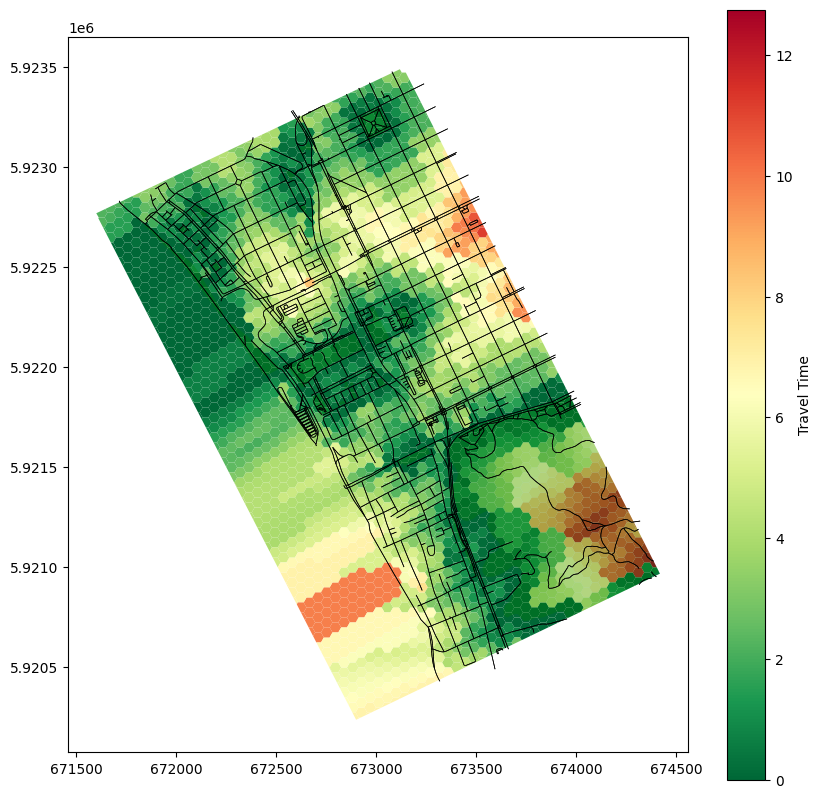

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

nodes_df, edges_df = tui.st.get_current_nodes_and_edges()

# Crear una figura y un eje
fsize = 10
fig, ax = plt.subplots(figsize=(fsize, fsize))

# Crear una paleta de colores personalizada usando RdYlGn
cmap = plt.get_cmap('RdYlGn_r')  # La '_r' indica que la paleta se invierte

# Crear una barra de colores personalizada
norm = mcolors.Normalize(vmin=min(tui.gdf_ga_paths['travel_time']), vmax=max(tui.gdf_ga_paths['travel_time']))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Esto es necesario para que la barra de colores muestre los valores de la paleta

# Crear el gráfico de capas
tui.gdf_ga_paths.plot(column='travel_time', cmap=cmap, ax=ax)
ga.get_green_areas().plot(ax=ax, color='green', alpha=0.3)
gpd.sjoin(edges_df, tui.st.area_scope).plot(ax=ax, linewidth=0.5, color='black')
# nodes_df[nodes_df['osmid'].isin(failed_nodes)].plot(ax=ax, markersize=50, color='red')

# Agregar la barra de colores
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Travel Time')

# Mostrar el gráfico
plt.show()

In [8]:
nodes_df, edges_df = tui.st.get_current_nodes_and_edges()
net = st.current_scenario['net']
ga_idxs = ga.get_green_areas_ids()
ga_nodes_set = []
# idx = ga_idxs[10]
for idx in ga_idxs:
    points = pd.DataFrame(ga.get_countour_by_id(idx), columns=['x', 'y', 'key'])
    ga_nodes_ids = net.get_node_ids(points['x'], points['y'])
    ga_nodes = nodes_df[nodes_df['osmid'].isin(ga_nodes_ids)]
    ga_nodes['ID_AV'] = idx
    ga_nodes_set.append(ga_nodes)

ga_nodes_set = pd.concat(ga_nodes_set)
ga_nodes_set.drop_duplicates('osmid', inplace=True)

<Axes: >

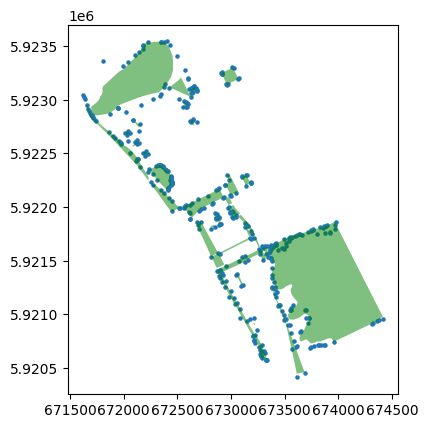

In [9]:
fig, ax = plt.subplots()
ga_nodes_set.plot(markersize=5, ax=ax)
tui.ga.get_green_areas().plot(ax=ax,color='green', alpha=0.5)

In [10]:
select_unit = 'hex'
unit = gpd.read_file(f'/app/assets/groupby/{select_unit}')
unit['centroid'] = unit['geometry'].centroid
unit['node_ids'] = net.get_node_ids(unit['centroid'].x, unit['centroid'].y)

In [11]:
paths_output = []
failed_nodes = []
for idx in range(len(unit)):
    # print(idx)
    source = unit.loc[idx, 'node_ids']
    source = [source]*len(ga_nodes_set)
    destination = ga_nodes_set['osmid']
    # print(source)
    # print(ga_nodes_set['osmid'])
    try:
        paths = net.shortest_path_lengths(source, ga_nodes_set['osmid'])
    except:
        print(f'Falló en el nodo {source[0]}')
        failed_nodes.append(source[0])
        paths = np.inf
    paths_df = pd.DataFrame.from_dict({
        'source': source,
        'destination': destination,
        'path_lengths': paths
    })
    paths_df.sort_values(by=['path_lengths'], inplace=True)
    paths_df.reset_index(inplace=True, drop=True)
    paths_df = paths_df.head(1)
    paths_df['ID_AV'] = ga_nodes_set[ga_nodes_set['osmid'] == paths_df.loc[0,'destination']]['ID_AV'].values[0]
    paths_df['hex_id'] = unit.loc[idx, 'hex_id']
    paths_output.append(paths_df)

paths_output = pd.concat(paths_output)
paths_output.reset_index(inplace=True, drop=True)

Falló en el nodo 202436804
Falló en el nodo 202436825
Falló en el nodo 202436822
Falló en el nodo 202436818
Falló en el nodo 202436783
Falló en el nodo 202436816
Falló en el nodo 202436800


In [12]:
paths_output = pd.merge(paths_output, unit, on='hex_id')

In [13]:
columns = ['source', 'destination', 'path_lengths', 'ID_AV', 'hex_id', 'geometry']
gdf_ga_paths = gpd.GeoDataFrame(data=paths_output.drop(columns=['geometry']), geometry=paths_output['geometry'])
gdf_ga_paths = gdf_ga_paths[columns]
def calcular_tiempo(distancia_metros):
    velocidad_kph = 4.5

    # Convertir la velocidad a metros por minuto
    velocidad_mpm = velocidad_kph * 1000 / 60
    
    # Calcular el tiempo en minutos
    tiempo = (distancia_metros / velocidad_mpm)
    
    return tiempo

gdf_ga_paths['travel_time'] = gdf_ga_paths['path_lengths'].apply(calcular_tiempo)

In [14]:
lim = 1000000000000000000000000000000000000000000000000000000000000
mask = (gdf_ga_paths['travel_time']<lim)

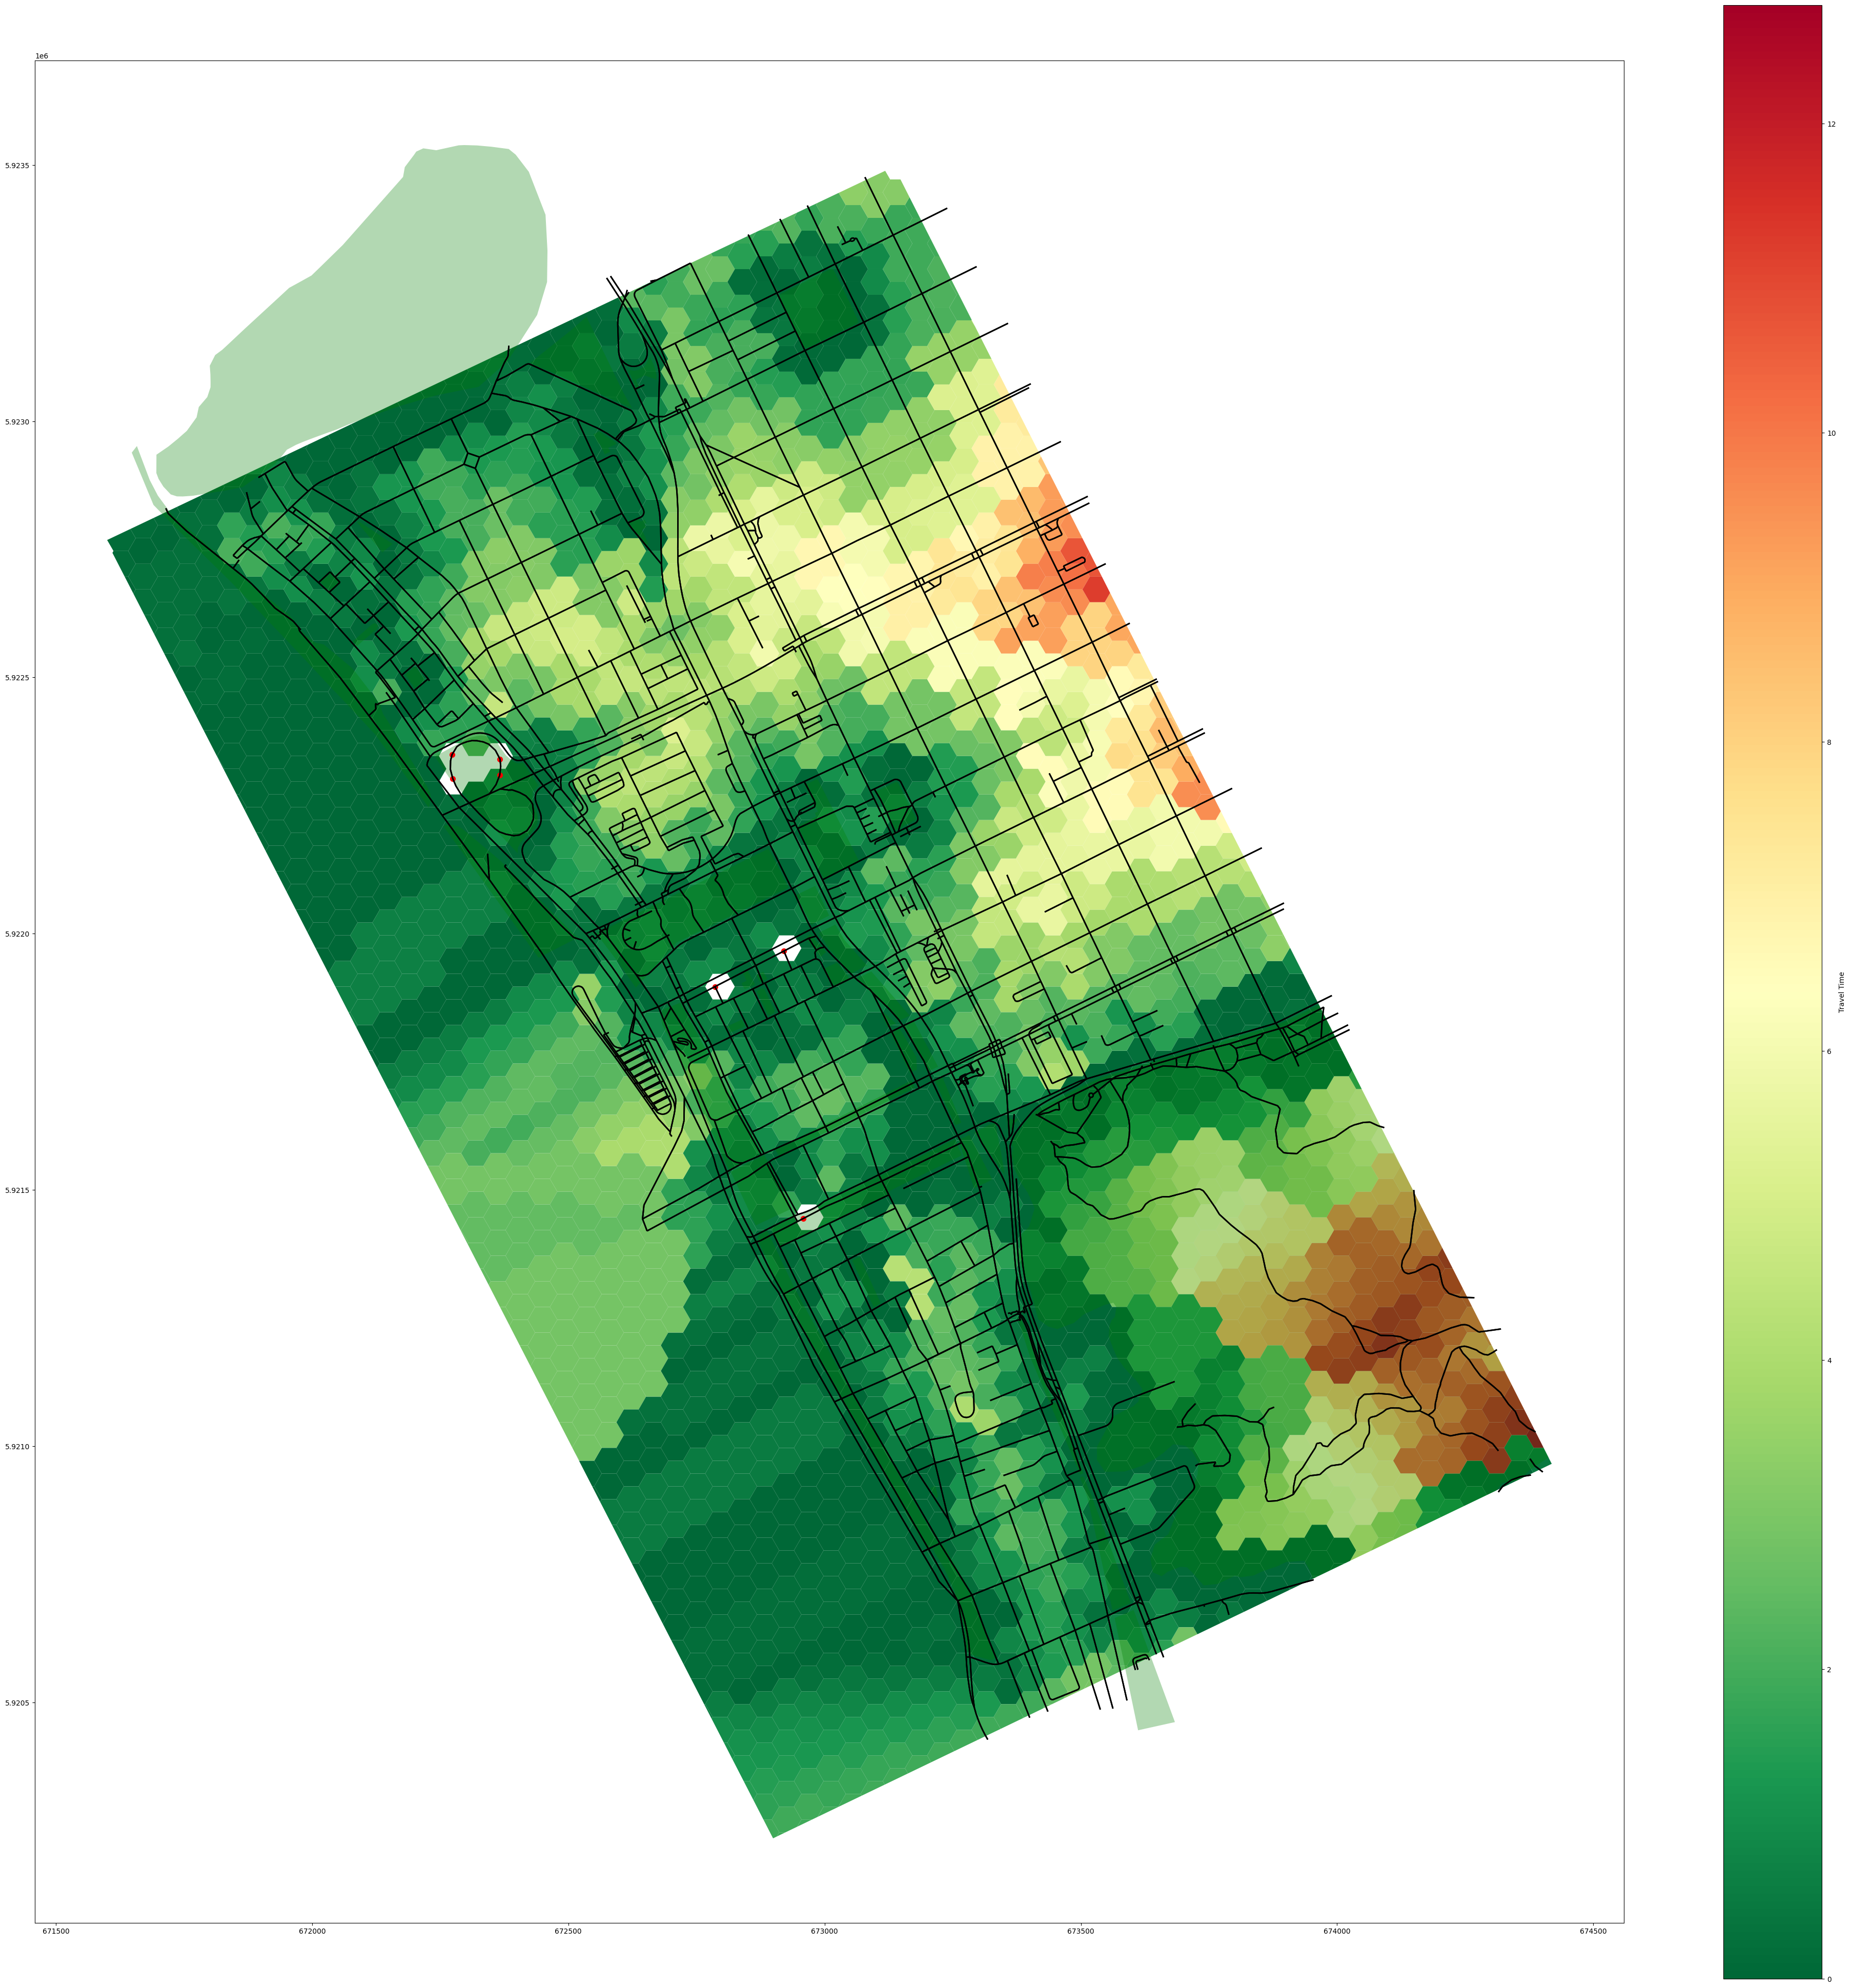

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

# Crear una figura y un eje
fsize = 50
fig, ax = plt.subplots(figsize=(fsize, fsize))

# Crear una paleta de colores personalizada usando RdYlGn
cmap = plt.get_cmap('RdYlGn_r')  # La '_r' indica que la paleta se invierte

# Crear una barra de colores personalizada
norm = mcolors.Normalize(vmin=min(gdf_ga_paths.loc[mask, 'travel_time']), vmax=max(gdf_ga_paths.loc[mask, 'travel_time']))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Esto es necesario para que la barra de colores muestre los valores de la paleta

# Crear el gráfico de capas
gdf_ga_paths[mask].plot(column='travel_time', cmap=cmap, ax=ax)
ga.get_green_areas().plot(ax=ax, color='green', alpha=0.3)
gpd.sjoin(edges_df, tui.st.area_scope).plot(ax=ax, linewidth=2, color='black')
nodes_df[nodes_df['osmid'].isin(failed_nodes)].plot(ax=ax, markersize=50, color='red')

# Agregar la barra de colores
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Travel Time')

# Mostrar el gráfico
plt.show()

In [13]:
nodes, edges = tui.st.get_current_nodes_and_edges()

In [11]:
fig, ax = plt.subplots(figsize=(100,100))
# tui.gdf_ga_paths.plot(column='travel_time', ax=ax)
tui.gdf_ga_paths[tui.gdf_ga_paths['travel_time'] > 100].plot(column='travel_time', ax=ax)
ga.get_green_areas().plot(ax=ax, color='green', alpha=0.3)
gpd.sjoin(tui.st.current_scenario['edges'], tui.st.area_scope).plot(ax=ax, linewidth=0.5)

nodes[nodes['osmid']==313193824].plot(ax=ax,color='blue',markersize=100)
nodes[nodes['osmid'].isin(tui.gdf_ga_paths[tui.gdf_ga_paths['travel_time'] > 100]['source'])].plot(ax=ax,color='red',markersize=10)


<Axes: >

In [ ]:
gdf_ga_paths.to_file('/app/data/test_ga_travel')